In [2]:
from google.colab import files
uploaded = files.upload()

Saving Online Retail.xlsx to Online Retail.xlsx


In [3]:
import pandas as pd

# Load file
df = pd.read_excel('Online Retail.xlsx', engine='openpyxl')

# Hapus transaksi tanpa CustomerID dan Quantity <= 0
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]

# Buat kolom total harga
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Lihat data sekilas
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [4]:
from datetime import datetime

# Ambil tanggal transaksi terakhir
latest_date = df['InvoiceDate'].max()

# RFM Aggregation
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40


In [5]:
from sklearn.preprocessing import StandardScaler

# Normalisasi fitur
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


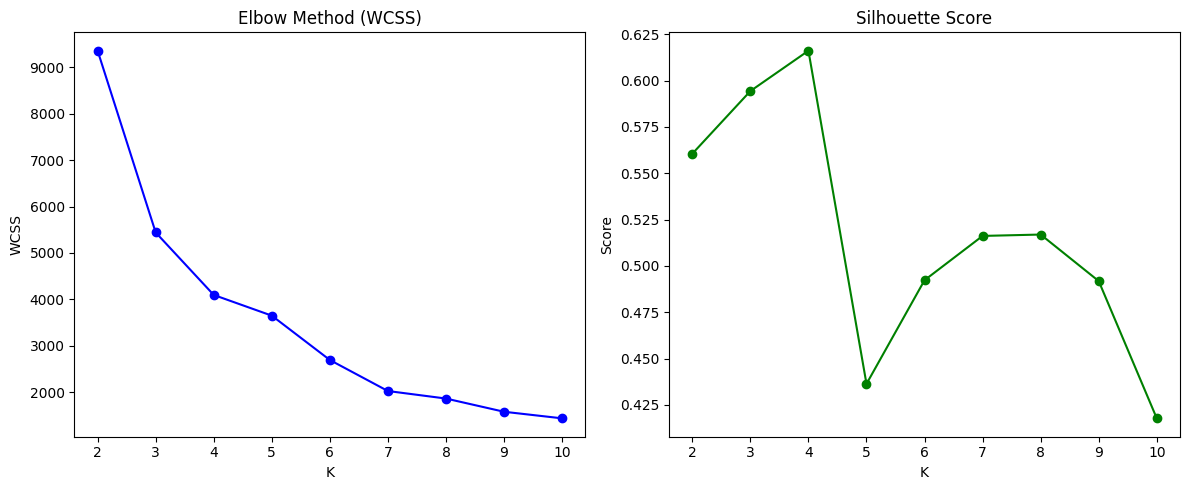

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

wcss = []
silhouette_scores = []

K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, wcss, 'bo-')
plt.title('Elbow Method (WCSS)')
plt.xlabel('K')
plt.ylabel('WCSS')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'go-')
plt.title('Silhouette Score')
plt.xlabel('K')
plt.ylabel('Score')

plt.tight_layout()
plt.show()


In [7]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Pilih jumlah cluster, misal 4
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(rfm_scaled)

# Evaluasi
print("Calinski-Harabasz Index:", calinski_harabasz_score(rfm_scaled, labels))
print("Davies-Bouldin Index:", davies_bouldin_score(rfm_scaled, labels))


Calinski-Harabasz Index: 3149.9947464162688
Davies-Bouldin Index: 0.7524015567669395


In [8]:
from scipy.spatial.distance import cdist
import numpy as np

def dunn_index(X, labels):
    clusters = np.unique(labels)
    distances = cdist(X, X)

    intra_dists = [np.max(distances[np.ix_(labels==i, labels==i)]) for i in clusters]
    inter_dists = [
        np.min(distances[np.ix_(labels==i, labels==j)])
        for i in clusters for j in clusters if i < j
    ]

    return np.min(inter_dists) / np.max(intra_dists)

print("Dunn Index:", dunn_index(rfm_scaled, labels))


Dunn Index: 0.0006147710808256576


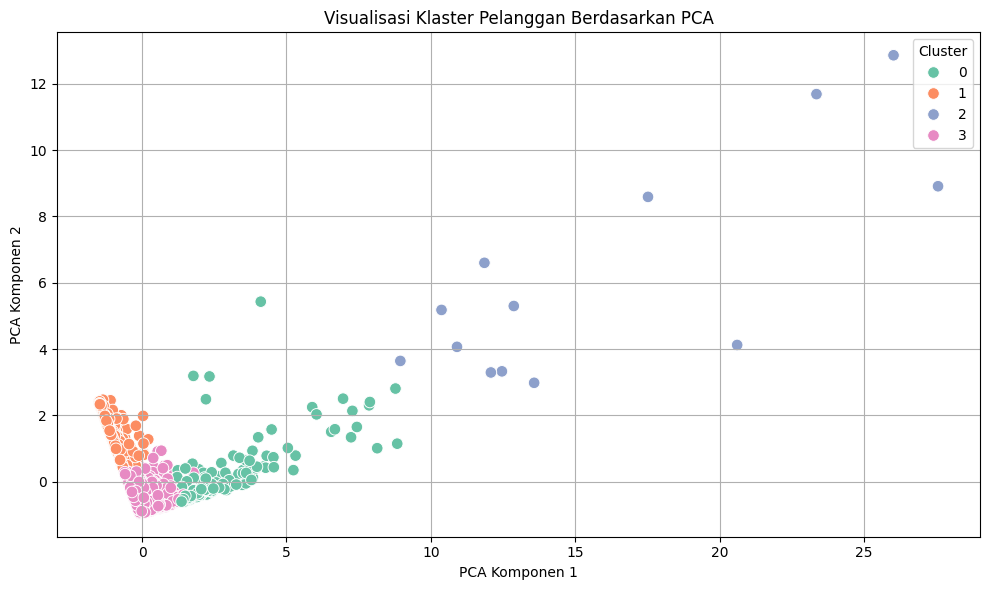

In [9]:
from sklearn.decomposition import PCA
import seaborn as sns

# Reduksi dimensi ke 2D
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

# Tambahkan hasil ke DataFrame
rfm['Cluster'] = labels
rfm['PCA1'] = pca_components[:, 0]
rfm['PCA2'] = pca_components[:, 1]

# Plot hasil klustering
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=70)
plt.title('Visualisasi Klaster Pelanggan Berdasarkan PCA')
plt.xlabel('PCA Komponen 1')
plt.ylabel('PCA Komponen 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()
